In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#### Matplotlib settings

In [73]:
plt.rcParams.update({'font.size': 14})

#### Read in Data

In [74]:
def read_ts(csv):
    df = pd.read_csv(
        f'data/{csv}.csv', 
        usecols = ['month', 'total.total'],
        parse_dates=['month'])
    df.index = df['month'].dt.to_period()
    df.drop(columns = 'month', inplace = True)
    df.columns = [csv]
    return df[csv]

In [75]:
editors = read_ts('editors')
total_views = read_ts('total_views')
legacy_views = read_ts('legacy_views')

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [76]:
editors.head()
legacy_views.head()
total_views.head()

month
2016-01    9330869593
2016-02    8684367374
2016-03    8802611656
2016-04    8932908573
2016-05    8816345693
Freq: M, Name: total_views, dtype: int64

In [77]:
editors.info()

<class 'pandas.core.series.Series'>
PeriodIndex: 253 entries, 2001-01 to 2022-01
Freq: M
Series name: editors
Non-Null Count  Dtype
--------------  -----
253 non-null    int64
dtypes: int64(1)
memory usage: 4.0 KB


### Merge Data

#### Combine legacy and total views to one series

In [78]:
merged_views = pd.DataFrame({'legacy': legacy_views, 'total_views': total_views})
merged_views.sample(10)

,legacy,total_views
month,,
2017-10,NaN,9.136097e+09
2020-07,NaN,9.717306e+09
2018-07,NaN,8.857186e+09
2021-08,NaN,9.745260e+09
2014-05,7.543278e+09,NaN
2014-03,7.464128e+09,NaN
2021-07,NaN,9.850698e+09
2008-03,4.955406e+09,NaN
2011-06,6.536676e+09,NaN


In [79]:
views = merged_views.max(axis = 1)
views

month
2007-12    2.998332e+09
2008-01    4.930903e+09
2008-02    4.818394e+09
2008-03    4.955406e+09
2008-04    5.159162e+09
               ...     
2021-09    9.217505e+09
2021-10    9.168265e+09
2021-11    8.668084e+09
2021-12    8.761074e+09
2022-01    9.676745e+09
Freq: M, Length: 170, dtype: float64

#### Add Editors

In [80]:
df = pd.DataFrame({'editors': editors, 'views': views})
df.head()

,editors,views
month,,
2001-01,110,NaN
2001-02,68,NaN
2001-03,164,NaN
2001-04,104,NaN
2001-05,139,NaN


### Plot Series

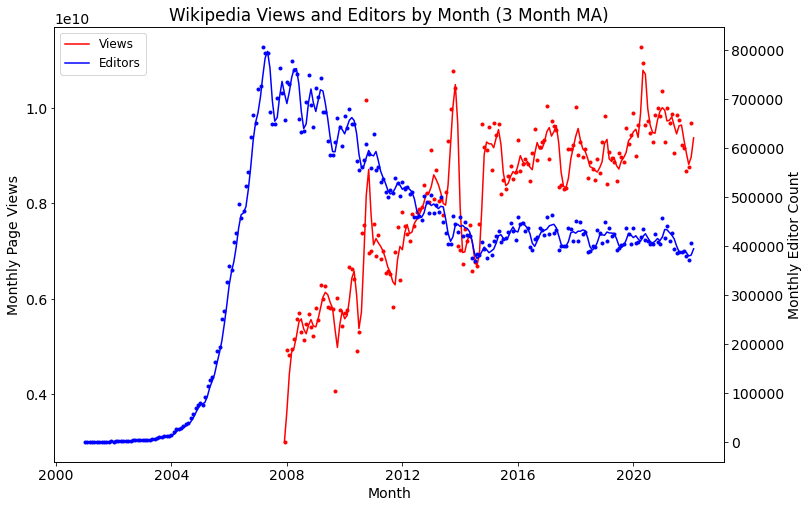

In [81]:
#Used https://pythonguides.com/matplotlib-two-y-axes/ as reference

plt.figure(figsize = (12, 8))

ax1 = plt.axes()
plt.plot(df['views'].to_timestamp(), '.r')
plot_1 = plt.plot(df['views'].rolling(
    window = 3, min_periods=1, center = True, win_type='triang').mean(),
    '-r', label = 'Views')
ax1.set_ylabel('Monthly Page Views', fontsize = 14)

ax2 = ax1.twinx()
plt.plot(df['editors'].to_timestamp(), '.b')
plot_2 = plt.plot(df['editors'].rolling(
    window = 3, min_periods=1, center = True, win_type='triang').mean(),
    '-b', label = 'Editors')
ax2.set_ylabel("Monthly Editor Count", fontsize = 14)

ax1.set_xlabel('Month', fontsize = 14)
plt.title('Wikipedia Views and Editors by Month (3 Month MA)')

lns = plot_1 + plot_2
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc = 'upper left', fontsize = 12)
plt.show()

### Correlation tables

The negative correlation between editors and views is reflecting the increasing trend in views vs the decreasing (stable since 2014) trend in editors.

In [82]:
df.corr()

,editors,views
editors,1.00000,-0.77921
views,-0.77921,1.00000


However, the change in editors is positively correlated with change in views, suggesting that the difference in views may be a good predictor of editors.

In [83]:
df.diff().corr() 

,editors,views
editors,1.000000,0.557582
views,0.557582,1.000000


### Auto correlations

In [84]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The auto correlation plot shows high correlations at all lags, indicating the data should be differenced first.
Additonally, the partial auto correlation plot confirms this by showing low partial auto correlations after the first term.

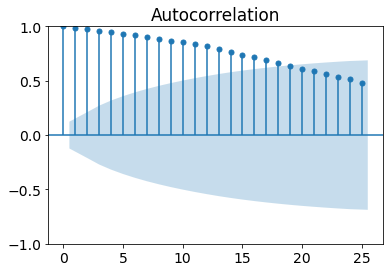

In [85]:
plot_acf(editors);

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


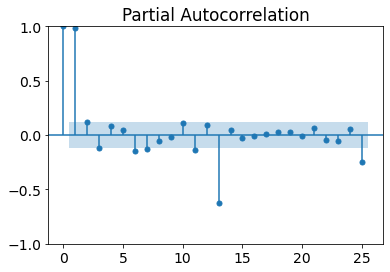

In [86]:
plot_pacf(editors);

After one difference, the auto correlation function is showing high correlation at lags 12 and 24.
This indicates a seasonal auto regressive component.

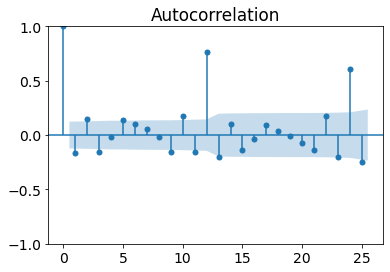

In [87]:
plot_acf(editors.diff()[1:]);

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


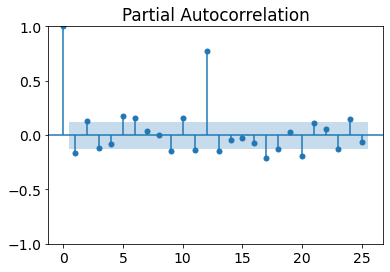

In [88]:
plot_pacf(editors.diff()[1:]);

These plots suggest a good sarima model is (0, 1, 0) x (1, 0, 0)

#### Views Autocorrelations

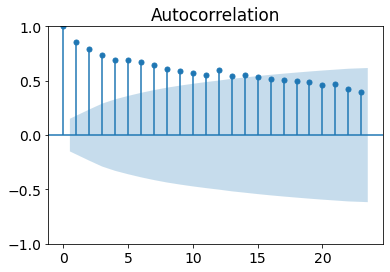

In [89]:
plot_acf(views);

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


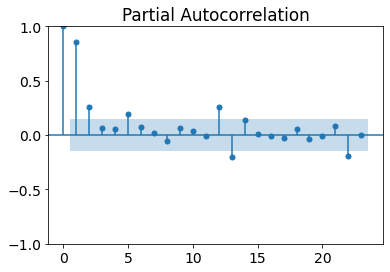

In [90]:
plot_pacf(views);

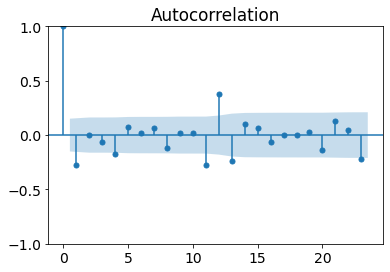

In [91]:
plot_acf(views.diff()[1:]);

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


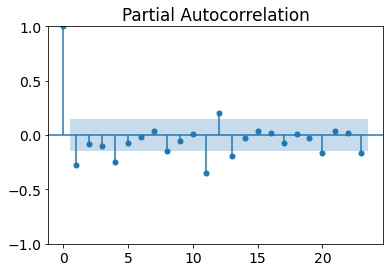

In [92]:
plot_pacf(views.diff()[1:]);

### Predicting number of editors

In [93]:
from sklearn.model_selection import train_test_split

In [126]:
y= df['editors']
y_train, y_test = train_test_split(y, test_size=24, shuffle= False) # predict last 2 years

<AxesSubplot:xlabel='month'>

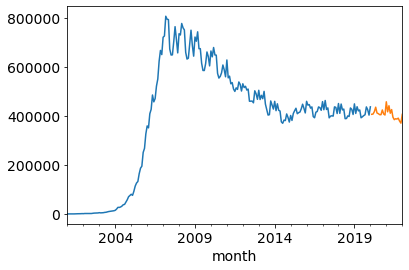

In [127]:
y_train.plot()
y_test.plot()

In [133]:
def plot_preds(col):
    plt.figure(figsize=(12,8))

    y_train.plot(color = 'blue', label = 'train')
    y_test.plot(color = 'orange', label = 'test')
    preds_df[col].plot(color = 'green', label = col)

    plt.xlabel('Year')
    plt.ylabel('Number of Editors')
    plt.title('Predicted vs Actual Editor Numbers')

    plt.legend(loc='best')
    plt.show()

In [134]:
preds_df = pd.DataFrame({'test': y_test})

#### Baseline Model

In [135]:
preds_df['baseline'] = y_train.iloc[-1] #Last prediction

In [124]:
# preds_df

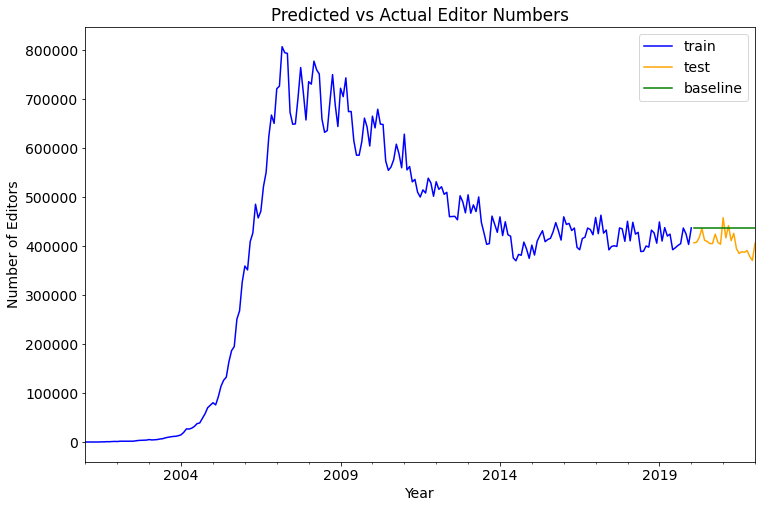

In [136]:
plot_preds('baseline')

In [137]:
mean_absolute_error(y_test, preds_df['baseline'])

31270.125

#### Holt Winters

In [138]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [139]:
hw = ExponentialSmoothing(
    y_train,
    seasonal_periods = 12,
    trend = 'add',
    seasonal = 'mul',
    damped_trend = True
).fit()
hw.summary()

C:\Users\slitv\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,editors,No. Observations:,229
Model:,ExponentialSmoothing,SSE,130964055353.998
Optimized:,True,AIC,4651.663
Trend:,Additive,BIC,4710.036
Seasonal:,Multiplicative,AICC,4655.299
Seasonal Periods:,12,Date:,"Fri, 25 Feb 2022"
Box-Cox:,False,Time:,15:49:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2525000,alpha,True
smoothing_trend,0.1983929,beta,True


In [140]:
preds_df['hw'] = hw.forecast(len(y_test))

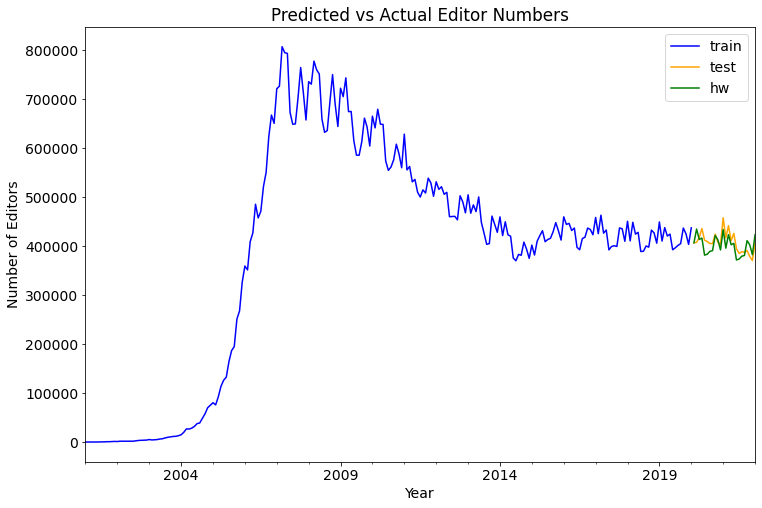

In [141]:
plot_preds('hw')

In [142]:
mean_absolute_error(y_test, preds_df['hw'])

15491.801807444082

#### SARIMA (0, 1, 0)x(1, 0, 0)

In [143]:
from statsmodels.tsa.arima.model import ARIMA

In [144]:
sarima = ARIMA(
    y_train,
    order = (0, 1, 0), 
    seasonal_order = (0, 1, 0, 12)
).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          editors   No. Observations:                  229
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2454.297
Date:                          Fri, 25 Feb 2022   AIC                           4910.594
Time:                                  15:49:21   BIC                           4913.970
Sample:                              01-31-2001   HQIC                          4911.958
                                   - 01-31-2020                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.081e+08   2.09e+07     19.498      0.000    3.67e+08    4.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.26   Jarque-Bera (JB):               195.12
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

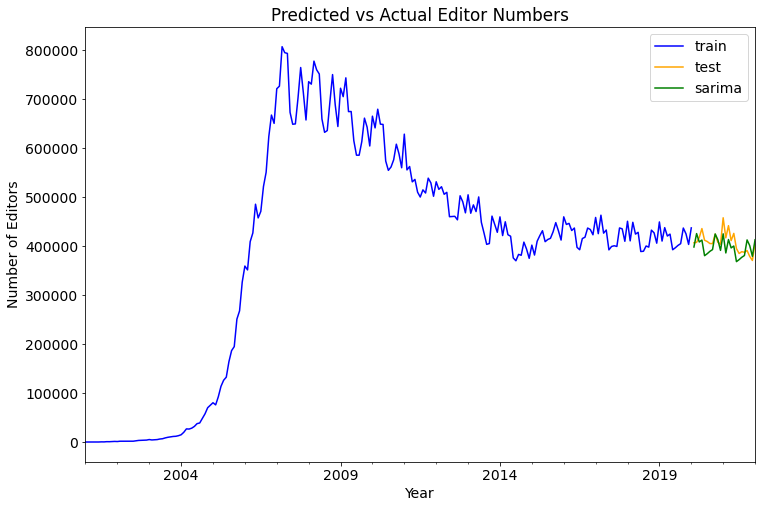

In [145]:
preds_df['sarima'] = sarima.forecast(len(y_test))
plot_preds('sarima')

In [146]:
mean_absolute_error(y_test, preds_df['sarima'])

17080.041666666668

### Predictions using views

#### Exogenous approach with SARIMAX

In [147]:
# Use diff as additional signal as views is non-stationary
df['views_diff'] = df['views'].diff() 
df_exog = df.dropna() # Note this excludes 7 years of training data before 2008
df_exog.head()

,editors,views,views_diff
month,,,
2008-01,734953,4.930903e+09,1.932571e+09
2008-02,729985,4.818394e+09,-1.125088e+08
2008-03,776885,4.955406e+09,1.370120e+08
2008-04,759269,5.159162e+09,2.037564e+08
2008-05,750610,5.584691e+09,4.255289e+08


In [148]:
y = df_exog['editors']
X = df_exog[['views', 'views_diff']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 24, shuffle = False)

In [149]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [150]:
sarimax = SARIMAX(
    y_train,
    exog = X_train,
    order = (0, 1, 0),
    seasonal_order = (1, 0, 0, 12),
).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          editors   No. Observations:                  229
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2454.297
Date:                          Fri, 25 Feb 2022   AIC                           4910.594
Time:                                  15:49:24   BIC                           4913.970
Sample:                              01-31-2001   HQIC                          4911.958
                                   - 01-31-2020                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.081e+08   2.09e+07     19.498      0.000    3.67e+08    4.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.26   Jarque-Bera (JB):               195.12
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
sarimax.params

views         1.684621e-05
views_diff   -4.627070e-06
ar.S.L12      2.184685e-01
sigma2        3.832645e+08
dtype: float64

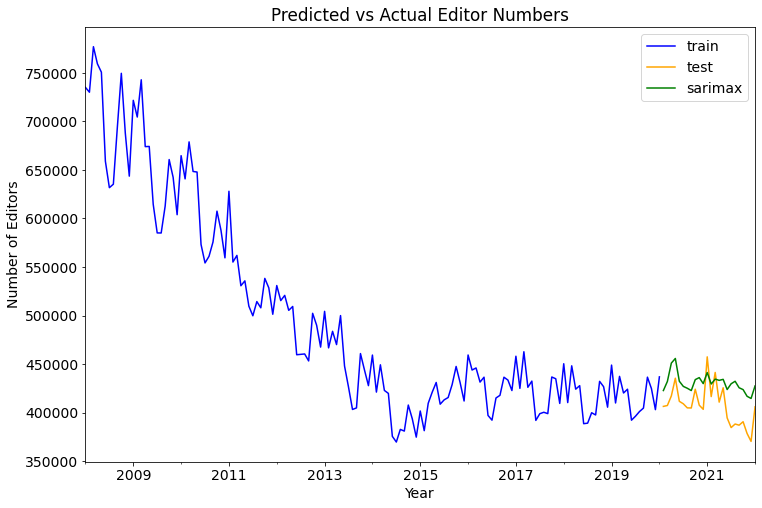

In [152]:
preds_df['sarimax'] = sarimax.forecast(len(y_test), exog = X_test)
plot_preds('sarimax')

In [153]:
mean_absolute_error(y_test, preds_df['sarimax'])

24906.582960073556

Worse performance might be corresponding to the increase in wikipedia readership during COVID without simulataneous increase in editors.